# Load Data From The Original Source On The Web 

In [ ]:
#loading in the library necessary
library(tidyverse)
install.packages("tidyverse")
library(repr)
library(tidymodels)
install.packages("themis")
library(themis)
options(repr.matrix.max.rows = 6)

In [13]:
#loads the data
cleveland <- read_csv("https://raw.githubusercontent.com/JennWan/Group_Project/main/new%20data/newcleveland_data.csv", col_names = F)

Rows: 303 Columns: 15
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (10): X2, X3, X6, X7, X9, X11, X12, X13, X14, X15
dbl  (5): X1, X4, X5, X8, X10

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


# Wrangling and Cleaning The Data

In [3]:
#renaming variables for readability 
colnames(cleveland) <- c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", 
                         "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num")

#selecting predictors of interest
cleveland_tidy <- cleveland |>
                select(age, cp, trestbps, chol, fbs, thalach, exang, ca, thal, num) |>
                mutate(age = as.integer(age), 
                       trestbps = as.integer(trestbps), 
                       chol = as.integer(chol), 
                       thalach = as.integer(thalach), 
                       cp = as_factor(cp), 
                       fbs = as_factor(fbs), 
                       exang = as_factor(exang), 
                       ca = as.integer(ca), 
                       ca = as_factor(ca), 
                       thal = as_factor(thal), 
                       num = as_factor(num)) |>
                filter(!is.na(ca), !is.na(thal))

cleveland_tidy

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `ca = as.integer(ca)`.
Caused by warning:
! NAs introduced by coercion”


age,cp,trestbps,chol,fbs,thalach,exang,ca,thal,num
<int>,<fct>,<int>,<int>,<fct>,<int>,<fct>,<fct>,<fct>,<fct>
63,angina,145,233,true,150,fal,0,fix,buff
67,asympt,160,286,fal,108,true,3,norm,sick
67,asympt,120,229,fal,129,true,2,rev,sick
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
49,notang,118,149,fal,126,fal,3,norm,sick
74,abnang,120,269,fal,121,true,1,norm,buff
54,notang,160,201,fal,163,fal,1,norm,buff


In [4]:
# find the number and percentage of differing presence of heart disease observations in our data set
# to check for class imbalance

num_obs <- nrow(cleveland_tidy)
    cleveland_tidy |>
    group_by(num) |>
    summarize(
        count = n(),
        percentage = n() / num_obs * 100)

num,count,percentage
<fct>,<int>,<dbl>
buff,161,54.02685
sick,137,45.97315


In [5]:
# center, scaling and balancing the heart disease data
cleve_recipe <- recipe(num ~ ., data = cleveland_tidy) |>
    step_scale(trestbps, chol, thalach) |>
    step_center(trestbps, chol, thalach) |>
    step_upsample(num, over_ratio = 1, skip = FALSE) |>
    prep()

preprocessed_cleve <- bake(cleve_recipe, cleveland_tidy)
preprocessed_cleve

age,cp,trestbps,chol,fbs,thalach,exang,ca,thal,num
<int>,<fct>,<dbl>,<dbl>,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>
63,angina,0.75947933,-0.2679748,true,0.02321445,fal,0,fix,buff
37,notang,-0.08945105,0.0596218,fal,1.63304188,fal,0,norm,buff
41,abnang,-0.08945105,-0.8268160,fal,0.98040914,fal,0,norm,buff
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
52,asympt,-1.1081675,-0.3257859,fal,0.45830295,fal,1,norm,sick
67,notang,1.1556468,-0.6726529,fal,0.02321445,fal,0,rev,sick
42,asympt,0.2501211,1.3121969,fal,-1.06450678,true,0,fix,sick


In [6]:
# find the number and percentage of differing presence of heart disease observations in our data set
# double check class imbalance

num_obs <- nrow(preprocessed_cleve)
    preprocessed_cleve |>
    group_by(num) |>
    summarize(
        count = n(),
        percentage = n() / num_obs * 100)

num,count,percentage
<fct>,<int>,<dbl>
buff,161,50
sick,161,50


In [7]:
# create the TRAIN SET and TEST SET
set.seed(2000)

cleveland_split <- initial_split(preprocessed_cleve, prop = 0.75, strata = num)
cleveland_train <- training(cleveland_split) 
cleveland_test <- testing(cleveland_split)

## Exploration of Model Predictors

In [8]:
# create tbl to compare the average_age for each stage of heart disease presence and arrange by average_age
exploration_tbl1 <- cleveland_train |>
    group_by(num) |>
    summarize(avg_age = mean(age)) |>
    arrange(avg_age)

exploration_tbl1

# create tbl to compare average_chol for each stage of heart disease presence and arrange by average_colestoral
exploration_tbl2 <- cleveland_train |>
    group_by(num) |>
    summarize(avg_chol = mean(chol)) |>
    arrange(avg_chol)

exploration_tbl2

# create tbl to compare average_max_heartrate for each stage of heart disease presence and arrange by average_max_heartrate
exploration_tbl3 <- cleveland_train |>
    group_by(num) |>
    summarize(avg_max_heartrate = mean(thalach)) |>
    arrange(avg_max_heartrate)

exploration_tbl3

num,avg_age
<fct>,<dbl>
buff,52.675
sick,57.250


num,avg_chol
<fct>,<dbl>
buff,0.008555275
sick,0.141520938


num,avg_max_heartrate
<fct>,<dbl>
sick,-0.5608918
buff,0.4343731


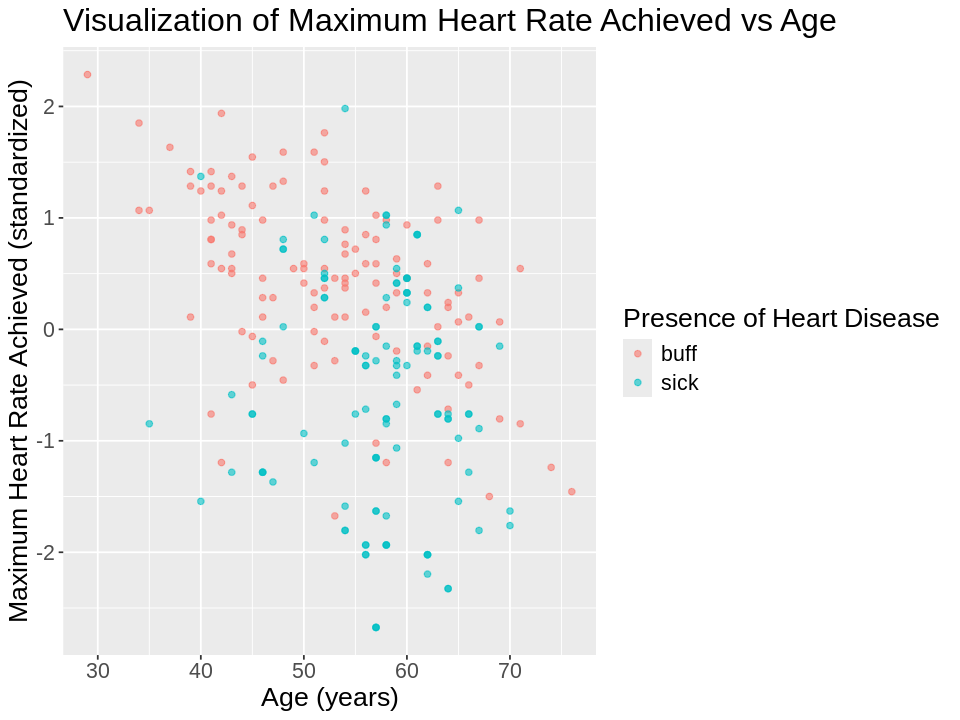

In [9]:
# draw a scatter plot to visualize the relationship between the age and thalach (maximum heart rate achieved) predictors/variables

options(repr.plot.height = 6, repr.plot.width = 8)
exploration_plot2 <- cleveland_train |>
  ggplot(aes(x = age, y = thalach, color = num)) +
  geom_point(alpha = 0.6) +
  labs(x = "Age (years)",
       y = "Maximum Heart Rate Achieved (standardized)",
       color = "Presence of Heart Disease", 
       title = "Visualization of Maximum Heart Rate Achieved vs Age") + 
  theme(text = element_text(size = 16))

exploration_plot2

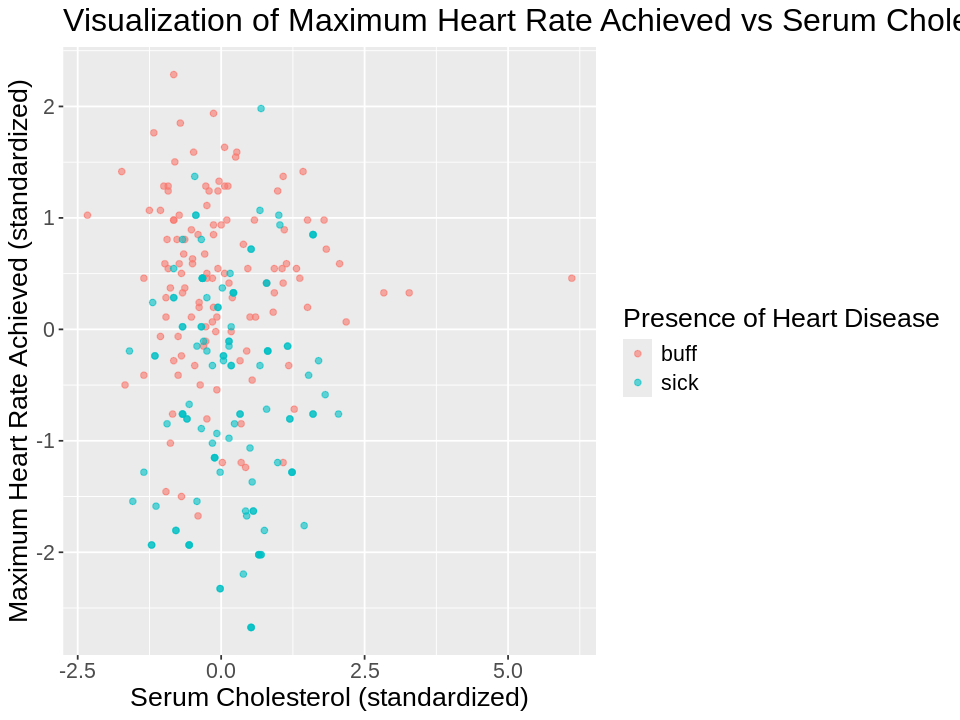

In [10]:
# draw a scatter plot to visualize the relationship between chol (serum cholestoral in mg/d) and thalach (maximum heart rate achieved) predictors/variables

options(repr.plot.height = 6, repr.plot.width = 8)
exploration_plot3 <- cleveland_train |>
  ggplot(aes(x = chol, y = thalach, color = num)) +
  geom_point(alpha = 0.6) +
  labs(x = "Serum Cholesterol (standardized)",
       y = "Maximum Heart Rate Achieved (standardized)",
       color = "Presence of Heart Disease", 
       title = "Visualization of Maximum Heart Rate Achieved vs Serum Cholesterol") + 
  theme(text = element_text(size = 16))

exploration_plot3

## Predictor Exploration Analysis
*/Our tables are relevant in assisting our analysis towards answering our question, as it demonstrates the possible relationship between each predictor and our class. Where within all the tables one in particular clearly demonstrates that there are some positive relationship between the predictor age and num, the presence of heart disease.

Our plots help visually protray further relationship between more variables, whereas there is no clear relationship observed.

To conclude, within the previous tables and plots there does not seem to be any obvious relationship other than the positive relationship between age and the presence of heart disease. It is oberved that between age and the presence of heart disease, num, there is a moderately positive linear relationship where the increase of age has a correlationing increase in the presence of heart disease./*

# Data Analysis

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.8204949,7,0.02294360,Preprocessor1_Model01
6,accuracy,binary,0.8127918,7,0.02054155,Preprocessor1_Model02
11,accuracy,binary,0.8167600,7,0.01757844,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
66,accuracy,binary,0.8246965,7,0.02592088,Preprocessor1_Model14
71,accuracy,binary,0.8242297,7,0.02608015,Preprocessor1_Model15
76,accuracy,binary,0.8202614,7,0.02307503,Preprocessor1_Model16


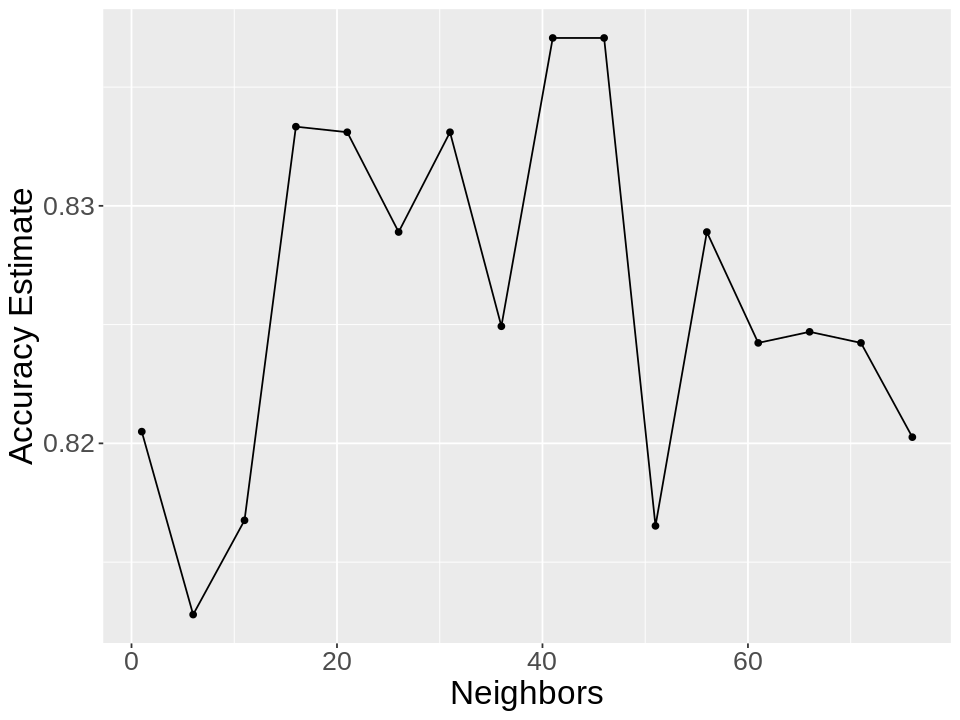

In [18]:
# find the best k neighbour value to use with V-fold cross validation
cleveland_vfold <- vfold_cv(cleveland_train, v = 7, strata = num)

cleveland_recipe <- recipe(num ~ ., data = cleveland_tidy) |>
    step_scale(trestbps, chol, thalach) |>
    step_center(trestbps, chol, thalach) |>
    step_upsample(num, over_ratio = 1, skip = T) |>
    prep()

cleveland_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
            set_engine("kknn") |>
            set_mode("classification")

gridvals = tibble(neighbors = seq(from = 1, to = 80, by = 5))

set.seed(2000)

cleveland_results <- workflow() |>
            add_recipe(cleveland_recipe) |>
            add_model(cleveland_spec) |>
            tune_grid(resamples = cleveland_vfold, grid = gridvals) |>
            collect_metrics() |>
            filter(.metric == "accuracy")
cleveland_results

# plot k values against their respective accuracies and choose optimal k value
cross_val_plot <- cleveland_results |> 
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate") +
    theme(text = element_text(size = 20))
cross_val_plot

In [15]:
# compare the accuracy of predictions to the true values in the test set

cleveland_best_knn <- cleveland_results |>
                    

cleveland_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 11) |>
  set_engine("kknn") |>
  set_mode("classification")

cleveland_fit <- workflow() |>
  add_recipe(cleveland_recipe) |>
  add_model(cleveland_best_spec) |>
  fit(data = cleveland_train)

cleveland_predictions <- predict(cleveland_fit, cleveland_test) |> 
    bind_cols(cleveland_test)

cleveland_acc <- cleveland_predictions |> 
    metrics(truth = num, estimate = .pred_class) |> 
    select(.metric, .estimate) |> 
    head(1)

cleveland_acc
cleveland_cm <- cleveland_predictions |> 
    conf_mat(truth = num, estimate = .pred_class)
cleveland_cm

cleveland_best_graph <- cleveland_predictions

.metric,.estimate
<chr>,<dbl>
accuracy,0.8780488


          Truth
Prediction buff sick
      buff   37    6
      sick    4   35

### Work Cited
Marateb HR, Goudarzi S. A noninvasive method for coronary artery diseases diagnosis using a clinically-interpretable fuzzy rule-based system. J Res Med Sci. 2015 Mar;20(3):214-23. PMID: 26109965; PMCID: PMC4468223.